# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [4]:
# Create X and y
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

#### Estimating a manually Decision Tree Classifier

In [5]:
# The Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly 
# labeled if it was labeled by the distribution of samples in the node.
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [6]:
# The gini imputiry of the split is the Gini Impurity of each node is weighted by the fraction of points 
# from the parent node in that node.
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [7]:
# test all splits on all features
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [8]:
# Recursively grow the tree
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain


    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [9]:
# Prediction
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

#### Evaluating accuracy on testing set

In [10]:
tree = tree_grow(X_train, y_train, max_depth=6)

In [11]:
y_pred = tree_predict(X_test, tree)

In [12]:
print('Accuracy on testing set:',accuracy_score(y_test, y_pred))

Accuracy on testing set: 0.8771889400921659


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [13]:
np.random.seed(111)

n_samples = X_train.shape[0]
n_estimators = 10

# create 10 bootstrap samples
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for i in range(n_estimators)]

In [14]:
# Train Decision Tree Classifiers
trees = {}
for i in range(n_estimators):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], max_depth=6)

In [15]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred = (y_pred_df.sum(axis=1) >= n_estimators*0.5).astype(np.int)

In [16]:
print('Accuracy on testing set:',accuracy_score(y_test, y_pred))

Accuracy on testing set: 0.8794930875576037


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

#### Implementing max_features on the Decision Tree Classifier

In [17]:
# randomly choising n features
def n_features(n):
    n_samples = range(X_train.shape[1])
    n_features = n
    features = np.random.choice(a=n_samples, size=n_features, replace=False)
    return features
    
n_features(2)

array([6, 0])

In [18]:
# test all splits on all features
def best_split(X, y, num_pct=10, max_features=None):
    
    if max_features is None:
        features = range(X.shape[1])
    else:
        features = n_features(max_features) #randomly choising n features
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [19]:
# Recursively grow the tree
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=None):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct, max_features) #randomly choising n features
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain


    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, max_features=max_features)
    
    return tree

#### Comparing impact on the results by varying max_features

In [36]:
max_feature = range(X_train.shape[1]+1)

results = []

for feature in max_feature:
    tree = tree_grow(X_train, y_train, max_depth=6, max_features=feature)
    y_pred = tree_predict(X_test, tree)
    results.append(accuracy_score(y_test, y_pred))

(0.8783410138248848, 8)


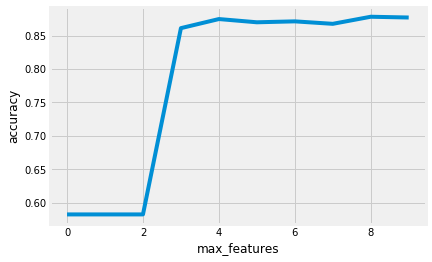

In [37]:
plt.plot(max_feature,results)
plt.xlabel('max_features')
plt.ylabel('accuracy')
print(sorted(zip(results,max_feature))[::-1][0])

#### Evaluate accuracy on testing set

In [40]:
tree = tree_grow(X_train, y_train, max_depth=6, max_features=8)

In [41]:
y_pred = tree_predict(X_test, tree)
print('Accuracy on testing set:',accuracy_score(y_test, y_pred))

Accuracy on testing set: 0.8785714285714286


# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [50]:
np.random.seed(111)

n_samples = X_train.shape[0]
n_estimators = 10

# create 10 bootstrap samples
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for i in range(n_estimators)]

In [51]:
# Train Decision Tree Classifiers
trees = {}
for i in range(n_estimators):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], max_depth=6, max_features=int(round(log(X_train.shape[1]),0)))

In [52]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

y_pred = (y_pred_df.sum(axis=1) >= n_estimators*0.5).astype(np.int)

In [53]:
print('Accuracy on testing set:',accuracy_score(y_test, y_pred))

Accuracy on testing set: 0.852073732718894


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [54]:
clf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy for Random Forest is {}'.format(accuracy_score(y_test, y_pred)))

Accuracy for Random Forest is 0.8423963133640553


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

#### Tuning n_estimators

In [55]:
# values to try for n_estimators
estimator_range = range(1, 100,10)

# Store average accuracy for each value of n_estimator
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

(0.8403790622481507, 11)


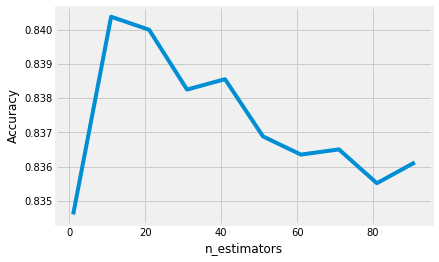

In [56]:
plt.plot(estimator_range, accuracy_scores)
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
print(sorted(zip(accuracy_scores,estimator_range))[::-1][0])

#### Tuning max_features

In [57]:
# values to try for max_features
feature_range = range(1, len(X.columns)+1)

# Store average accuracy for each max_feature
accuracy_scores = []

# use 5-fold cross-validation with each value of max_features
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=11, n_jobs=-1, max_features=feature)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

(0.8460068437655345, 7)


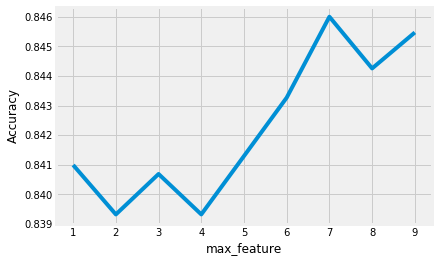

In [58]:
plt.plot(feature_range,accuracy_scores)
plt.xlabel('max_feature')
plt.ylabel('Accuracy')
print(sorted(zip(accuracy_scores,feature_range))[::-1][0])

#### Tuning max_depth

In [62]:
# values to try for max_depth
depth_range = range(440,900,50)

# Store average accuracy for each max_depth value
accuracy_scores = []

#
for depth in depth_range:
    cfl = RandomForestClassifier(n_estimators=11, max_features=7, max_depth=depth, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

(0.8475274384163702, 740)


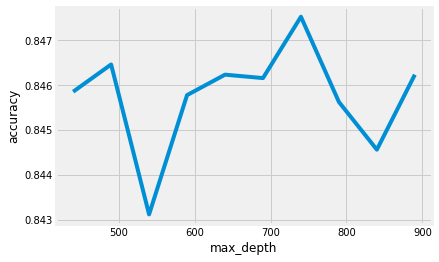

In [63]:
plt.plot(depth_range,accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
print(sorted(zip(accuracy_scores,depth_range))[::-1][0])

**Best parameters** fo Random Forest Classifier are:

- n_estimators: 11
- max_features: 7
- max_depth: 740

In [64]:
clf = RandomForestClassifier(n_estimators=11, max_features=7, max_depth=740, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy for Random Forest is {}'.format(accuracy_score(y_test, y_pred)))

Accuracy for Random Forest is 0.843778801843318
